In [2]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
warnings.filterwarnings("ignore")

In [3]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [4]:
col.unique(columns='source_id');

In [5]:
# uniques = col.unique(columns=["source_id"])
col.search(source_id='GFDL-CM4',activity_id='CMIP',experiment_id='piControl',table_id=['Omon','Oyr']).unique(columns='variable_id');
# uniques

In [6]:
variables = ['dissic','talk','so','thetao']
z_kwargs = {'consolidated': True, 'decode_times':False}
query = dict(experiment_id=['piControl'], table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn','gr'],
             source_id=['CanESM5-CanOE', 'CanESM5', 'ACCESS-ESM1-5',
                        'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC-ES2L',
                        'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NorCPM1',
                        'NorESM1-F', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4'])
cat = col.search(**query)
# print(cat.df['source_id'].unique())
dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs,
                                preprocess=combined_preprocessing)

temp={}
for name,item in dset_dict.items():
#     print(name)
#     print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        temp[name]=dset_dict[name]
dset_dict = temp
dset_dict


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found


{'CMIP.NOAA-GFDL.GFDL-ESM4.piControl.Omon.gr': <xarray.Dataset>
 Dimensions:    (lev: 35, member_id: 1, time: 6000, x: 360, y: 180)
 Coordinates:
   * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
   * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
   * time       (time) int64 0 708 1416 2148 ... 4377060 4377792 4378524 4379256
     lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
     lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * member_id  (member_id) <U8 'r1i1p1f1'
 Data variables:
     dissic     (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 16, 35, 180, 360), meta=np.ndarray>
     so         (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 35, 35, 180, 360), meta=np.ndarray>
     talk       (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 17, 

In [7]:
def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

def calc_PpCO2(ds):
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,pressure=0)
    return ds['talk'].copy(data=results['pCO2'])

def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

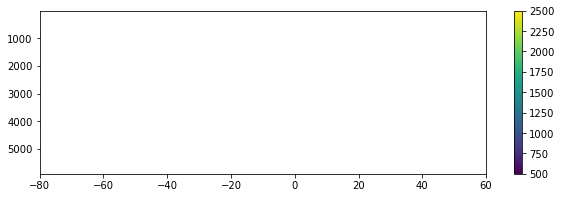

In [114]:
fig, ax = plt.subplots(figsize=[10,3])
ds = dset_dict['CMIP.IPSL.IPSL-CM6A-LR.piControl.Omon.gn'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
if 'member_id' in ds.dims:
    ds = ds.isel(member_id=0)
pco2 = calc_PpCO2(ds)
sigma2 = calc_sigma2(ds)
meridionalsection_with_sigma2(ax,pco2,sigma2,clims=[500,2500],title=ds.attrs['intake_esm_dataset_key'])

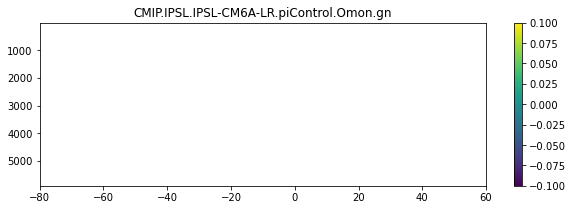

In [117]:
fig, ax = plt.subplots(figsize=[10,3])
ds = dset_dict['CMIP.IPSL.IPSL-CM6A-LR.piControl.Omon.gn'].isel(time=0).sel(x=190.5)
if 'member_id' in ds.dims:
    ds = ds.isel(member_id=0)
meridionalsection(ax,ds['dissic'],title=ds.attrs['intake_esm_dataset_key'])

In [1]:
dset_dict

NameError: name 'dset_dict' is not defined

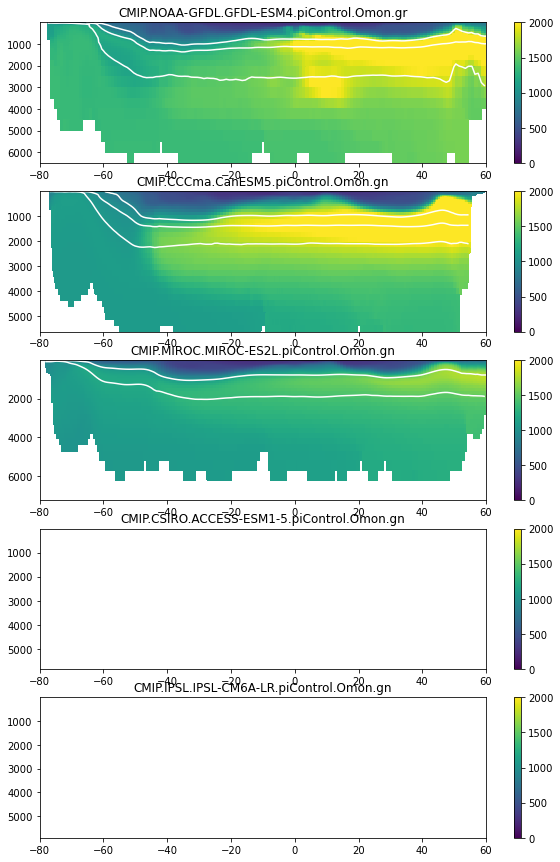

In [8]:
### MULTIPLE MODELS
n = len(dset_dict.items())
fig, axarr = plt.subplots(nrows=n,figsize=[10,3*n])
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    ds = ds.isel(time=1200).sel(x=slice(180,200)).mean('x',keep_attrs=True)
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    pco2 = calc_PpCO2(ds)
    sigma2 = calc_sigma2(ds)
    meridionalsection_with_sigma2(ax,pco2,sigma2,clims=[0,2000],title=ds.attrs['intake_esm_dataset_key'])